In [1]:
import numpy as np
import networkx as nx
import itertools
import matplotlib.pyplot as plt

In [2]:
%alias_magic t timeit -p "-n1 -r1"

Created `%t` as an alias for `%timeit -n1 -r1`.
Created `%%t` as an alias for `%%timeit -n1 -r1`.


In [3]:
a=np.load("UUU-top1000-5frag-4A.npz")

'''
a.keys() = ['max_rmsd',
             'interactions-2',
             'interactions-3',
             'interactions-0',
             'interactions-1',
             'nfrags']
'''

interactions = [a['interactions-%i'%i] for i in range(4)]
print([a['interactions-%i'%i].shape[0] for i in range(4)], "=", sum(len(a['interactions-%i'%i]) for i in range(4)))
print([np.unique(a['interactions-%i'%i][:,0]).shape[0] for i in range(4)],
       np.unique(a['interactions-%i'%3][:,1]).shape[0], "=",
       sum([np.unique(a['interactions-%i'%i][:,0]).shape[0] for i in range(4)],
       np.unique(a['interactions-%i'%3][:,1]).shape[0]))

[1321, 1133, 1351, 4018] = 7823
[281, 197, 175, 219] 440 = 1312


In [4]:
interactions_nn = []

In [5]:
%%t
for int_level in range(len(interactions)):
    curIntLevel = []
    for int_pair in range(interactions[int_level].shape[0]):
        curIntLevel.append([str(interactions[int_level][int_pair][0]) + "_" + str(int_level),
                            str(interactions[int_level][int_pair][1]) + "_" + str(int_level+1)])

    interactions_nn.append(curIntLevel)

26.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [6]:
DG = nx.DiGraph()
for int_level in range(len(interactions_nn)):
    for edge in interactions_nn[int_level]:
        DG.add_edge(*edge)
DG.number_of_nodes(), DG.number_of_edges()

(1312, 7823)

In [7]:
unique_input_id = np.unique(interactions[0][:,0])
unique_output_id = np.unique(interactions[3][:,1])

unique_input_node = [i for i in DG.nodes() if "_0" in i]
unique_output_node = [i for i in DG.nodes() if "_4" in i]

# Méthode brute : long...

In [9]:
%%timeit -r1 -n 1
count = 0
in_out_combo = itertools.product(unique_input_node, unique_output_node)
for in_node, out_node in in_out_combo:
    this_count = len([i for i in nx.all_simple_paths(DG, source=in_node, target=out_node)])
    count += this_count
    #print (this_count)
print(count)

565507
10min 38s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### PLot

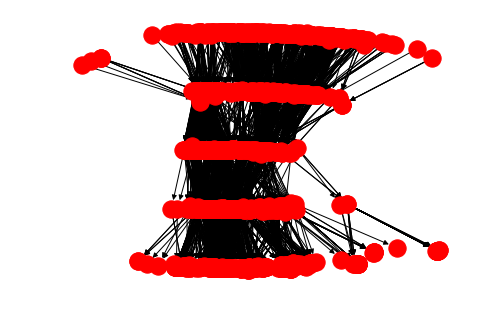

In [11]:
nx.draw_kamada_kawai(DG)
plt.show()

# Est-ce que le graphe est composé de sous-graphes ?
Divulgachage : Non.

In [12]:
def resetGraph(DG):
    for node in DG.nodes:
        DG.nodes[node]['lowest_parent'] = -1

def setGraph(DG, index):
    for node in DG.nodes:
        DG.nodes[node]['lowest_parent'] = index
    
def explore_subGraph(DG, from_node, index):
    DG.nodes[from_node]['lowest_parent'] = index
    for p_node in DG.successors(from_node):
        if DG.nodes[p_node]['lowest_parent'] != index:
            explore_subGraph(DG, p_node, index)
    for p_node in DG.predecessors(from_node):
        if DG.nodes[p_node]['lowest_parent'] != index:
            explore_subGraph(DG, p_node, index)

resetGraph(DG)
explore_subGraph(DG, unique_input_node[0], 0)
for node in DG.nodes:
    if DG.nodes[node]['lowest_parent'] != 0:
        print(node, "\t", DG.nodes[node]['lowest_parent'])